In [6]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import easygui
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt



In [3]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
#dir_name = easygui.diropenbox()
dir_name = '/home/abuzarmahmood/Downloads/'
os.chdir(dir_name)

#open file
#open dump file
with open('znormdiff_array', 'rb') as f:
    znormdiff_matrix = pickle.load(f)

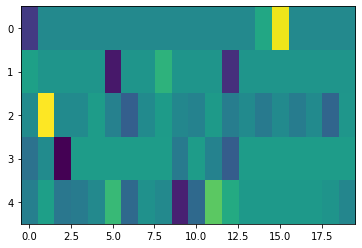

In [8]:
#print(znormdiff_matrix)
plt.imshow(znormdiff_matrix,aspect='auto',cmap='viridis')

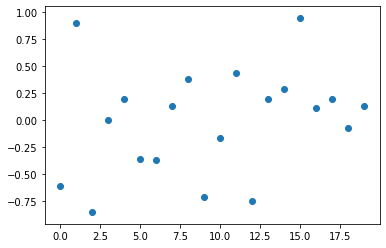

In [17]:
#diff vector
zdiff_mean = np.nanmean(znormdiff_matrix,axis=0)
plt.scatter(np.arange(len(zdiff_mean)),zdiff_mean)

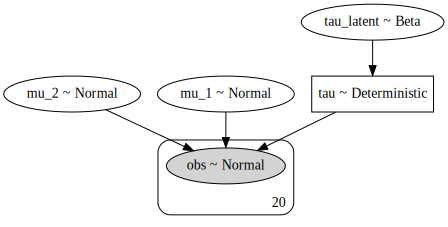

In [10]:
#count_data
#count_data = np.sum(znormdiff_matrix,axis=0)
count_data = zdiff_mean
n_count_data = len(count_data)

with pm.Model() as model:
    # Defining variables with priors
    alpha = count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    
    # Using unequal variances
    
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)

with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    a = 3
    b = 3
    tau_latent = pm.Beta('tau_latent', a, b)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = weight * mu_1 + (1 - weight) * mu_2  

with model:
    observation = pm.Normal("obs", mu=mu_, observed=count_data)


pm.model_to_graphviz(model)



In [11]:
with model:
    trace = pm.sample(15000, tune=5000, chains = 8, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [tau_latent, mu_2, mu_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 160000/160000 [00:33<00:00, 4730.17draws/s]


In [12]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_1,0.12,0.35,-0.51,0.80,0.00,0.00,70697.0,46126.0,73620.0,57679.0,1.0
mu_2,-0.11,0.34,-0.75,0.52,0.00,0.00,71659.0,43106.0,75474.0,62710.0,1.0
tau_latent,0.51,0.20,0.14,0.85,0.00,0.00,75645.0,75645.0,73423.0,74624.0,1.0
tau,9.63,3.75,2.76,16.22,0.01,0.01,75645.0,75645.0,73423.0,74624.0,1.0


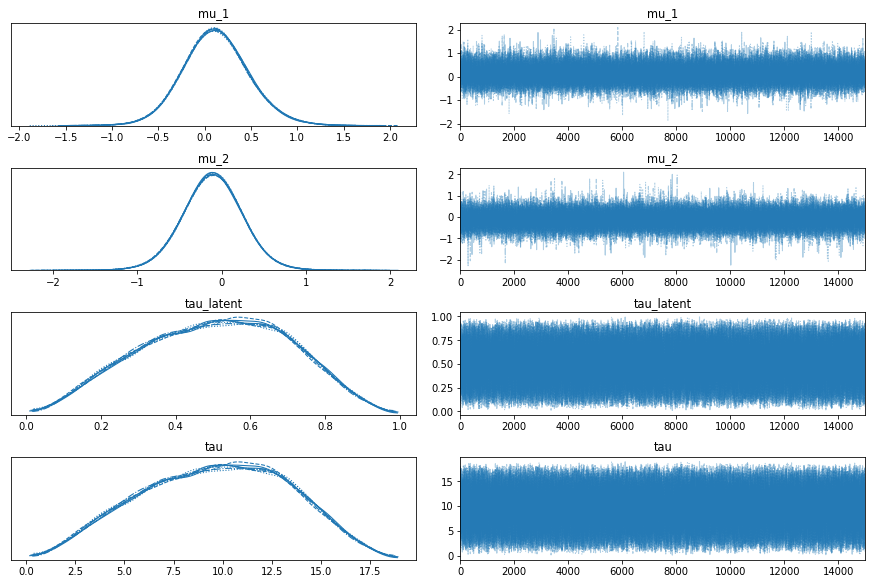

In [13]:
pm.traceplot(trace);

In [14]:
ppc = pm.sample_posterior_predictive(trace, samples = 10000, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:07<00:00, 1304.31it/s]


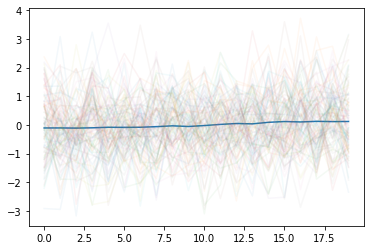

In [15]:
plt.plot(np.mean(ppc['obs'],axis=0));
traces = 100
plt.plot(ppc['obs'][:100].T, alpha = 0.05);